# Análisis de Licencias Médicas

Este notebook contiene análisis y consultas sobre las licencias médicas usando SQLModel.

### Imports

In [1]:
from sqlmodel import Session, select, func

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configurar matplotlib para mejor visualización
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
import os
import sys

# Obtener el directorio actual (notebooks)
current_dir = os.getcwd()
# Obtener el directorio raíz del proyecto (un nivel arriba de notebooks)
project_root = os.path.dirname(current_dir)

print(f"Directorio actual: {current_dir}")
print(f"Directorio raíz del proyecto: {project_root}")

# Agregar el directorio raíz al path para poder importar los módulos
sys.path.append(project_root)

# Verificar que el path se agregó
print(f"Path agregado: {project_root}")
print(f"¿Existe el directorio app? {os.path.exists(os.path.join(project_root, 'app'))}")


Directorio actual: /Users/jloyola/Workspace/python-refresh-suseso/notebooks
Directorio raíz del proyecto: /Users/jloyola/Workspace/python-refresh-suseso
Path agregado: /Users/jloyola/Workspace/python-refresh-suseso
¿Existe el directorio app? True


In [3]:
from app.database.connection import engine
from app.models.licencias_medicas import LicenciaMedica

print("Importaciones realizadas")

Importaciones realizadas


In [4]:
session = Session(engine)
print("Conexión a la base de datos establecida")

Conexión a la base de datos establecida


### Número de licencias por CCAF

In [ ]:
from typing import Sequence, Tuple

# Obtener número de licencias por cada CCAF
def get_number_of_licenses_by_ccaf() -> Sequence[Tuple[str, int]]:
    """Obtener el número de licencias por CCAF"""
    statement = select(LicenciaMedica.ccaf, func.count()).group_by(LicenciaMedica.ccaf)
    return session.exec(statement).all()

def get_number_of_licenses_of_ccaf(ccaf: str = "") -> int:
    """Obtener el número de licencias de un CCAF específico"""
    statement = select(func.count()).where(LicenciaMedica.ccaf == ccaf)
    return session.exec(statement).one()


In [6]:
results = get_number_of_licenses_by_ccaf()
df_licencias_por_ccaf = pd.DataFrame(results, columns=['CCAF', 'Número de licencias'])
df_licencias_por_ccaf.sort_values(by='Número de licencias', ascending=False, inplace=True)

print("Número de licencias por CCAF:")
display(df_licencias_por_ccaf.style.hide(axis="index"))

Número de licencias por CCAF:


CCAF,Número de licencias
Los Andes,418
Los Héroes,415
Gabriela Mistral,402
18 de Septiembre,399
La Araucana,353


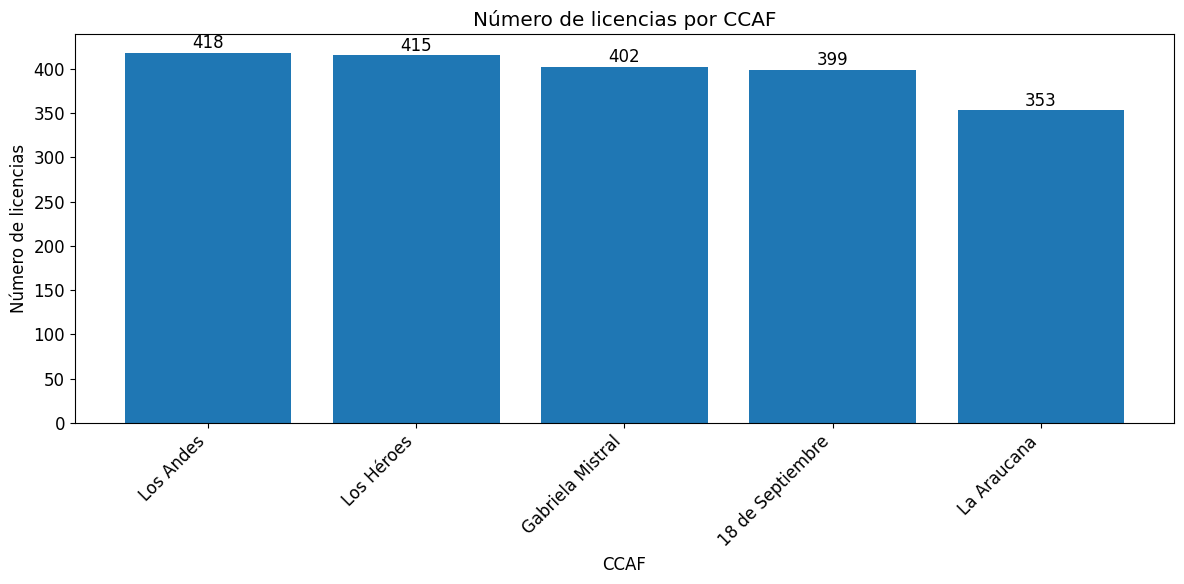


Estadísticas:
Total de licencias: 1987
Promedio de licencias por CCAF: 397.40
CCAF con más licencias: Los Andes
CCAF con menos licencias: La Araucana


In [15]:
# Crear un gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(df_licencias_por_ccaf['CCAF'], df_licencias_por_ccaf['Número de licencias'])
plt.title('Número de licencias por CCAF')
plt.xlabel('CCAF')
plt.ylabel('Número de licencias')
plt.xticks(rotation=45, ha='right')

# Agregar números en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Mostrar estadísticas básicas
print("\nEstadísticas:")
print(f"Total de licencias: {df_licencias_por_ccaf['Número de licencias'].sum()}")
print(f"Promedio de licencias por CCAF: {df_licencias_por_ccaf['Número de licencias'].mean():.2f}")
print(f"CCAF con más licencias: {df_licencias_por_ccaf.loc[df_licencias_por_ccaf['Número de licencias'].idxmax(), 'CCAF']}")
print(f"CCAF con menos licencias: {df_licencias_por_ccaf.loc[df_licencias_por_ccaf['Número de licencias'].idxmin(), 'CCAF']}")

### Beneficiarios con licencias reiteradas

In [16]:
session.rollback()
session.close()
session = Session(engine)

In [17]:
# WITH r AS (
#   SELECT beneficiario_id,
#          COUNT(*) AS lics_12m,
#          ccaf
#   FROM licencias_medicas
#   WHERE fecha_emision >= CURRENT_DATE - INTERVAL '12 months'
#   GROUP BY beneficiario_id, ccaf
# )
# SELECT * FROM r WHERE lics_12m >= 3;

from typing import List, Tuple
from datetime import date, timedelta

def get_beneficiarios_con_muchas_licencias() -> Sequence[Tuple[int, int, str]]:
    """Obtener beneficiarios con 3 o más licencias en los últimos 12 meses"""
    
    statement = (
        select(
            LicenciaMedica.beneficiario_id, 
            func.count().label("lics_12m"),
            LicenciaMedica.ccaf
        )
        .where(LicenciaMedica.fecha_emision >= date.today() - timedelta(days=365))
        .group_by(LicenciaMedica.beneficiario_id, LicenciaMedica.ccaf) # type: ignore
        .having(func.count() >= 3)
    )
    return session.exec(statement).all()

results = get_beneficiarios_con_muchas_licencias()
print(f"Encontrados {len(results)} beneficiarios con 3+ licencias")

# Mostrar algunos resultados
if results:
    print("\nPrimeros 5 beneficiarios con más licencias:")
    for beneficiario_id, count, ccaf in sorted(results, key=lambda x: x[1], reverse=True)[:5]:
        print(f"Beneficiario ID: {beneficiario_id}, Licencias: {count}, CCAF: {ccaf}")


Encontrados 16 beneficiarios con 3+ licencias

Primeros 5 beneficiarios con más licencias:
Beneficiario ID: 588, Licencias: 3, CCAF: Los Andes
Beneficiario ID: 1092, Licencias: 3, CCAF: 18 de Septiembre
Beneficiario ID: 1101, Licencias: 3, CCAF: Gabriela Mistral
Beneficiario ID: 1250, Licencias: 3, CCAF: Los Héroes
Beneficiario ID: 1951, Licencias: 3, CCAF: Los Andes


### Tamaño y composicion del gasto en licencias

In [18]:
# select
# 	lm.causa,
# 	sum(lm.monto_subsidio_clp) as total_clp,
# 	count(*) as n_licencias,
# 	avg(lm.dias_licencia) as dias_prom,
# 	min(lm.dias_licencia) as dias_min,
# 	max(lm.dias_licencia ) as dias_max
# from licencias_medicas  lm
# group by causa
# order by total_clp desc;

def get_cant_licencias_por_causa():
	"""Obtener la cantidad de licencias por causa"""
	statement = (
		select(
			LicenciaMedica.causa,
			func.sum(LicenciaMedica.monto_subsidio_clp).label("total_clp"),
			func.count().label("n_licencias"),
			func.avg(LicenciaMedica.dias_licencia).label("dias_prom"),
			func.min(LicenciaMedica.dias_licencia).label("dias_min"),
			func.max(LicenciaMedica.dias_licencia).label("dias_max")
		) # type: ignore
		.group_by(LicenciaMedica.causa)
		.order_by(func.sum(LicenciaMedica.monto_subsidio_clp).desc())
	)
	return session.exec(statement).all()

In [19]:
results = get_cant_licencias_por_causa()
df_licencias_por_causa = pd.DataFrame(results, columns=['Causa', 'Total Subsidio CLP', 'Número de licencias', 'Días promedio', 'Días mínimo', 'Días máximo'])
df_licencias_por_causa.sort_values(by='Total Subsidio CLP', ascending=False, inplace=True)

# Formatear las columnas
df_licencias_por_causa['Total Subsidio CLP'] = df_licencias_por_causa['Total Subsidio CLP'].apply(lambda x: f"{x:,}")
df_licencias_por_causa['Días promedio'] = df_licencias_por_causa['Días promedio'].apply(lambda x: f"{float(x):.2f}".rstrip('0').rstrip('.'))

print("Número de licencias por Causa:")
display(df_licencias_por_causa.style.hide(axis="index"))

Número de licencias por Causa:


Causa,Total Subsidio CLP,Número de licencias,Días promedio,Días mínimo,Días máximo
Salud Mental,"131,133,188",304,12.18,1,56
Cuidados paliativos,"128,933,889",283,12.76,1,49
Accidente,"124,981,688",289,12.52,1,63
Enfermedad grave hijo <1,"120,402,959",279,12.12,1,52
Enfermedad común,"118,301,936",286,11.98,1,45
Maternidad,"114,286,080",284,12.12,1,58
COVID-19,"110,073,077",262,11.82,1,58


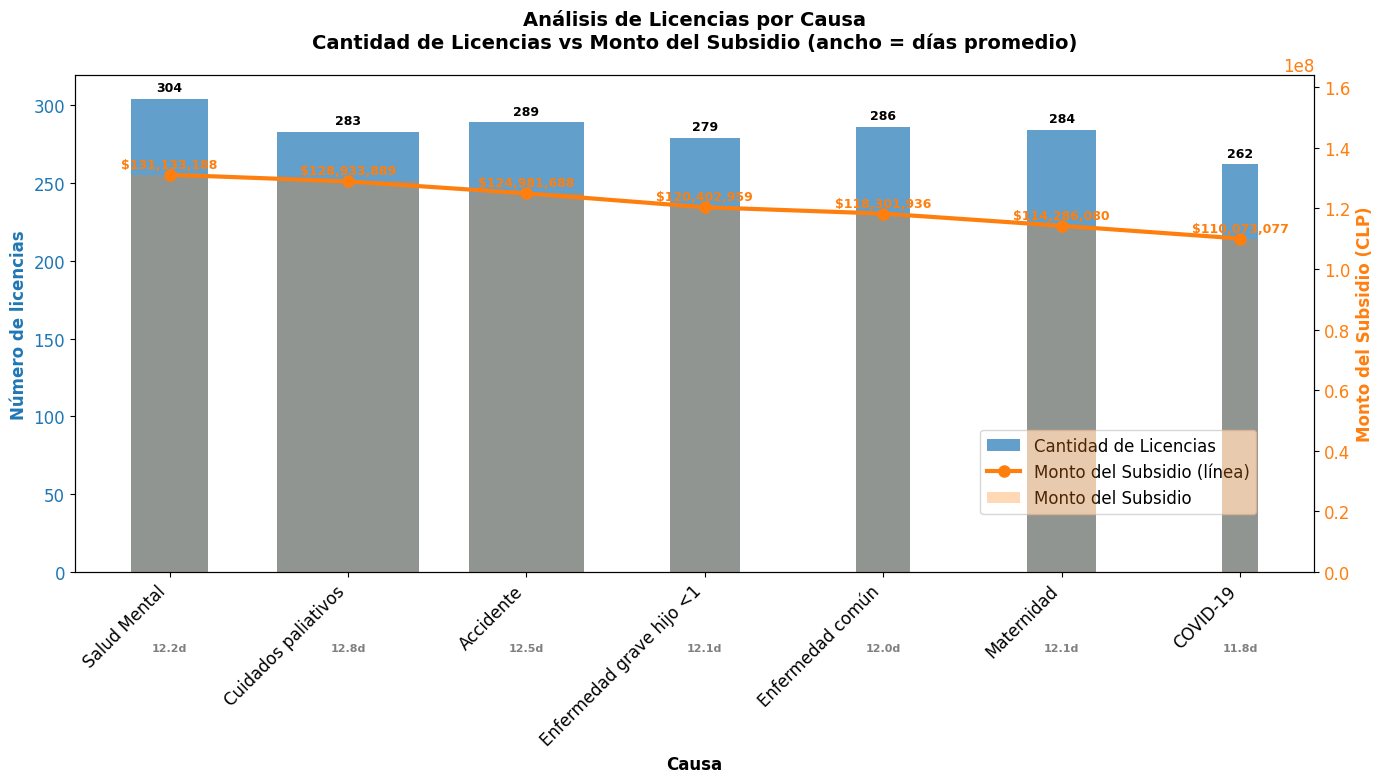

In [20]:
results = get_cant_licencias_por_causa()
df_causas = pd.DataFrame(results, columns=['causa', 'total_clp', 'n_licencias', 'dias_prom', 'dias_min', 'dias_max'])

# Crear un gráfico con doble eje Y
fig, ax1 = plt.subplots(figsize=(14, 8))

# Configurar el primer eje Y (izquierda) para cantidad de licencias
color1 = '#1f77b4'  # Azul
ax1.set_xlabel('Causa', fontsize=12, fontweight='bold')
ax1.set_ylabel('Número de licencias', color=color1, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color1)

# Crear barras con ancho variable basado en días promedio
# Normalizar los días promedio para que el ancho sea razonable
max_width = 0.8  # Ancho máximo de las barras
min_width = 0.2  # Ancho mínimo de las barras
dias_normalized = (df_causas['dias_prom'] - df_causas['dias_prom'].min()) / (df_causas['dias_prom'].max() - df_causas['dias_prom'].min())
dias_normalized = dias_normalized.astype(float)
widths = min_width + (max_width - min_width) * dias_normalized

# Crear las barras para cantidad de licencias
bars1 = ax1.bar(range(len(df_causas)), df_causas['n_licencias'], 
                width=widths, color=color1, alpha=0.7, 
                label='Cantidad de Licencias')
                
# Configurar el segundo eje Y (derecha) para monto del subsidio
ax2 = ax1.twinx()
color2 = '#ff7f0e'  # Naranja
ax2.set_ylabel('Monto del Subsidio (CLP)', color=color2, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, df_causas['total_clp'].max() * 1.25)

# Crear las barras para monto del subsidio (superpuestas pero transparentes para mostrar la línea)
bars2 = ax2.bar(range(len(df_causas)), df_causas['total_clp'], 
                width=widths, color=color2, alpha=0.3, 
                label='Monto del Subsidio')

# Agregar línea para el monto del subsidio
line = ax2.plot(range(len(df_causas)), df_causas['total_clp'], 
                color=color2, linewidth=3, marker='o', markersize=8,
                label='Monto del Subsidio (línea)')

# Configurar el eje X
ax1.set_xticks(range(len(df_causas)))
ax1.set_xticklabels(df_causas['causa'], rotation=45, ha='right')

# Agregar título
plt.title('Análisis de Licencias por Causa\nCantidad de Licencias vs Monto del Subsidio (ancho = días promedio)', 
          fontsize=14, fontweight='bold', pad=20)
          
# Agregar leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', bbox_to_anchor=(0.96, 0.1))

# Agregar valores en las barras
for i, (bar1, bar2, n_lic, monto, dias) in enumerate(zip(bars1, bars2, df_causas['n_licencias'], df_causas['total_clp'], df_causas['dias_prom'])):
    # Valor de licencias en la barra azul
    ax1.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + max(df_causas['n_licencias'])*0.01,
             f'{int(n_lic)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Valor del monto en la línea naranja
    ax2.text(i, monto + max(df_causas['total_clp'])*0.01,
             f'${monto:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold', color=color2)
    
    # Días promedio como ancho de barra
    ax1.text(bar1.get_x() + bar1.get_width()/2, -max(df_causas['n_licencias'])*0.15,
         f'{dias:.1f}d', ha='center', va='top', fontsize=8, fontweight='bold', color='gray')

# Ajustar layout
plt.tight_layout()

# Mostrar el gráfico
plt.show()

El gráfico superior muestra el monto total de subsidio, el número de licencias y el promedio de días de licencia por cada Tipo de licencia identificada (Causa).

El promedio de días de licencia está asociado al ancho de cada barra.
* Las licencias más largas (con un promedio de días mayor) corresponden a las asociadas a Cuidados paliativos (12.8 días). Las más cortas, en promedio, son las asociadas a COVID-19 (11.8 días).

En el eje y de la izquierda, con barras azules, se ve el número total de licencias por Causa.
* Se puede ver que la mayor cantidad de licencias está asociada a motivos de Salud Mental (304 licencias), seguido por Accidente (289) y Enfermedad común (296). 
* La menor cantidad de licencias está asociada a COVID-19 (262 licencias en total).

En el eje y de la derecha, en barras grises y línea naranja, está el monto total destinado por tipo de licencia.
* El mayor monto total de subsidio se ha destinado a licencias por Salud Mental, y el menor monto total está asociado a COVID-19.
* Si bien Accidente y Enfermedad común son 2da y 3ra en cantidad total de licencias, Cuidados paliativos supera a Accidente en monto total de subsidio otorgado, mientras que Enfermedad grave de hijo < 1 supera a Enfermedad común en el mismo item. Esto puede deberse a que, si bien la cantidad total de licencias por Accidente es mayor a la cantidad de licencias por Cuidados paliativos, el promedio de días solicitado por la segunda causa (12.8 días) es mayor que el promedio de días de licencia por Accidente (12.5), lo que podría estar asociado a un mayor monto total. De igual manera, el promedio de días solicitado por Enfermedad de hijo (12.1 días) es mayor a su vez que el promedio de días por Enfermedad común (12.0 días).

In [21]:
session.close()
print("Sesión cerrada")

Sesión cerrada
